# Question Answering with SQuAD 2.0 dataset and BERT-Base

In this assignment, our task was to  develop a model for question answering on
the dataset [SQuAD 2.0](https://rajpurkar.github.io/SQuAD-explorer/).

**Note:** due to limitations on the free version of google colab, the experiments on this assignment were executed on [Kaggle](https://www.kaggle.com/).

## First Steps

**GPU Info**

To get the same results (best ones) you should have a Tesla P100 GPU. This GPU is available for free usage on [Kaggle](https://www.kaggle.com/).

In [ ]:
!nvidia-smi

Sun Mar  6 19:38:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Install pytorch interface for pre-trained BERT**

Then, we will install the interface to use the pre-trained BERT model.

In [ ]:
!pip install transformers

**Import necessary libraries**

Now, it's time to import the necessary libraries for this notebook.

In [ ]:
import torch
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import re
import string
import collections
from transformers import BertTokenizerFast, BertForQuestionAnswering
from transformers.tokenization_utils_base import BatchEncoding
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

pd.set_option('max_colwidth', 500)
%matplotlib inline

**Enable CUDA**

Enable CUDA for GPU utilization by our model. This makes calculations and thus the training of our models faster.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

**Set random seed**

Set a constant random seed in order to get the same (deterministic) outputs every time we run our models.



In [ ]:
seed = 17064
def reset_seed():
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
reset_seed()

**BERT model definition**

And here, we define the name of the pre-trained bert model from [Hugging Face](https://huggingface.co/models) which we'll use.

In [ ]:
BERT_MODEL_NAME = 'bert-base-uncased'

## Dataset loading

Now, let's load our datasets:

**Define json preprocessing function**

First, we will define a function that takes a squad json dataset file path as argument and returns a dataframe with the questions, their answers in the form (start_position, end_position, answer_text) and the corpus that contains the answer to the corresponding question.

In [ ]:
def squad_load_from_json(json_file_path: str):
  with open(json_file_path, "r") as f:
    json_data = json.load(f)['data']
    questions = []
    answers = []
    corpuses = []
    for category in json_data:
      for paragraph in category['paragraphs']:
        context = paragraph['context']
        for qa in paragraph['qas']:
          corpuses.append(context)
          question = qa['question']
          questions.append(question)
          if qa['is_impossible']:
            ans_list = qa['plausible_answers']
          else:
            ans_list = qa['answers']
          ans_set = set()
          if len(ans_list) == 0:
            print("Question ", question, " has no answers")
          for idx, ans in enumerate(ans_list):
            ans_set.add((ans['answer_start'], ans['answer_start']+len(ans['text']), ans['text']))
          answers.append(list(ans_set))
    return pd.DataFrame(data={'question':questions, 'answer':answers, 'corpus':corpuses})

**Download the datasets**

Then we will download the train and validation datasets from the squad website and then convert them to pandas dataframes with the script above.

In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2022-03-06 19:39:18--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.110.153, 185.199.108.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   197MB/s    in 0.2s    

2022-03-06 19:39:19 (197 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2022-03-06 19:39:20--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

**Train Dataset**

In [ ]:
train_dataset = squad_load_from_json("train-v2.0.json")
train_dataset

,question,answer,corpus
0,When did Beyonce start becoming popular?,"[(269, 286, in the late 1990s)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
1,What areas did Beyonce compete in when she was growing up?,"[(207, 226, singing and dancing)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
2,When did Beyonce leave Destiny's Child and become a solo singer?,"[(526, 530, 2003)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
3,In what city and state did Beyonce grow up?,"[(166, 180, Houston, Texas)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
4,In which decade did Beyonce become famous?,"[(276, 286, late 1990s)]","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
...,...,...,...
130314,Physics has broadly agreed on the definition of what?,"[(485, 491, matter)]","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term ""matter"" usu..."
130315,Who coined the term partonic matter?,"[(327, 333, Alfvén)]","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (G

**Validation Dataset**

In [ ]:
validation_dataset = squad_load_from_json("dev-v2.0.json")
validation_dataset

Question  What was proven in 2001 in regard to the solid oxygen phase?  has no answers
Question  What was discovered in 2006 in regard to O4?  has no answers
Question  What does air in equilibrium with water contain?  has no answers
Question  What is paired oxygen?  has no answers
Question  Why are O molecules paramagnetic?  has no answers
Question  What is formula for the reactive oxygen ion?  has no answers
Question  What are products of oxygen use in organisms?   has no answers
Question  What began to accumulate 5.2 billion years ago?  has no answers
Question  What is red in both the liquid and solid states?  has no answers
Question  Why do polar oceans support reduced amounts of life?  has no answers
Question  What involves delivering a gas stream that is 9% to 93% O2?  has no answers
Question  What do oxoacids evolve from?  has no answers
Question  What is the essential purpose of supplementation?   has no answers
Question  In case of cabin pressurization, what is available to pas

,question,answer,corpus
0,In what country is Normandy located?,"[(159, 165, France)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
1,When were the Normans in Normandy?,"[(94, 117, 10th and 11th centuries), (87, 117, in the 10th and 11th centuries)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
2,From which countries did the Norse originate?,"[(256, 283, Denmark, Iceland and Norway)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
3,Who was the Norse leader?,"[(308, 313, Rollo)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
4,What century did the Normans first gain their separate identity?,"[(671, 675, 10th), (671, 683, 10th century), (649, 683, the first half of the 10th century)]","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
...,...,...,...
11868,What is the seldom used force unit equal to one thousand newtons?,"[(665, 671, sthène)]","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. The kilogram-force is not a part of the modern SI system, and is generally deprecated; however it still sees use for ..."
11869,What does not have a metric counterpart?,"[(4, 15, pound-force)]","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric s

**Exploding datasets on multiple answers**

Now, we will explode the datasets on the answers list field because it will help later.

In [ ]:
train_dataset = train_dataset.explode('answer').reset_index()
train_dataset

,index,question,answer,corpus
0,0,When did Beyonce start becoming popular?,"(269, 286, in the late 1990s)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
1,1,What areas did Beyonce compete in when she was growing up?,"(207, 226, singing and dancing)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
2,2,When did Beyonce leave Destiny's Child and become a solo singer?,"(526, 530, 2003)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
3,3,In what city and state did Beyonce grow up?,"(166, 180, Houston, Texas)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
4,4,In which decade did Beyonce become famous?,"(276, 286, late 1990s)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu..."
...,...,...,...,...
130314,130314,Physics has broadly agreed on the definition of what?,"(485, 491, matter)","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term ""matter"" usu..."
130315,130315,Who coined the term partonic matter?,"(327, 333, Alfvén)","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfv

In [ ]:
validation_dataset = validation_dataset.explode('answer').reset_index()
validation_dataset

,index,question,answer,corpus
0,0,In what country is Normandy located?,"(159, 165, France)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
1,1,When were the Normans in Normandy?,"(94, 117, 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
2,1,When were the Normans in Normandy?,"(87, 117, in the 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
3,2,From which countries did the Norse originate?,"(256, 283, Denmark, Iceland and Norway)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
4,3,Who was the Norse leader?,"(308, 313, Rollo)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ..."
...,...,...,...,...
16328,11868,What is the seldom used force unit equal to one thousand newtons?,"(665, 671, sthène)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. The kilogram-force is not a part of the modern SI system, and is generally deprecated; however it still sees use for ..."
16329,11869,What does not have a metric counterpart?,"(4, 15, pound-force)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. 

## Tokenization process

After loading the datasets, before we use them for the evaluation process, we must first tokenize them to calculate the gold answer start and end token positions.

**Download BERT tokenizer**

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Calculate start and end tokens of the answers**

In [ ]:
def calculate_tokenized_ans_indices(dataset: pd.DataFrame):
  ans_tok_start = []
  ans_tok_end = []
  ans_tok_text = []
  for idx, ans in enumerate(dataset['answer'].values):
    if not pd.isna(ans):
      ans_text_start = ans[0]
      ans_text_end = ans[1]
      ans_text = ans[2]
      encoding = tokenizer.encode_plus(text=dataset['corpus'].values[idx], text_pair=dataset['question'].values[idx], max_length=512, padding='max_length', truncation=True)
      ans_start = encoding.char_to_token(0, ans_text_start)
      ans_end = encoding.char_to_token(0, ans_text_end-1)
      # Handle truncated answers
      if ans_start is None:
        ans_start = ans_end = tokenizer.model_max_length
      elif ans_end is None:
        ans_end = [i for i, inp in enumerate(encoding['input_ids']) if inp == tokenizer.sep_token_id][0]
      # Wrong because it gives free score points on truncated answers. Fixed this on the cross evaluation script.
      ans_text_tok = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(encoding['input_ids'][ans_start:ans_end+1]))
    else:
      ans_start = ans_end = tokenizer.model_max_length
      ans_text_tok = ""
    ans_tok_start.append(ans_start)
    ans_tok_end.append(ans_end)
    ans_tok_text.append(ans_text_tok)
  dataset['ans_start_tok'] = ans_tok_start
  dataset['ans_end_tok'] = ans_tok_end
  dataset['ans_tok_text'] = ans_tok_text
  return dataset

In [ ]:
train_dataset = calculate_tokenized_ans_indices(train_dataset)
train_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,When did Beyonce start becoming popular?,"(269, 286, in the late 1990s)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",67,70,in the late 1990s
1,1,What areas did Beyonce compete in when she was growing up?,"(207, 226, singing and dancing)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",55,57,singing and dancing
2,2,When did Beyonce leave Destiny's Child and become a solo singer?,"(526, 530, 2003)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",128,128,2003
3,3,In what city and state did Beyonce grow up?,"(166, 180, Houston, Texas)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",47,49,"houston, texas"
4,4,In which decade did Beyonce become famous?,"(276, 286, late 1990s)","Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debu...",69,70,late 1990s
...,...,...,...,...,...,...,...
130314,130314,Physics has broadly agreed on the definition of what?,"(485, 491, matter)","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" matter, ""dark"" matter, ""anti""-matter, ""strange"" matter, and ""nuclear"" matter. In discussions of matter and antimatter, normal matter has been referred to by Alfvén as koinomatter (Gk. common matter). It is fair to say that in physics, there is no broad consensus as to a general definition of matter, and the term ""matter"" usu...",122,122,matter
130315,130315,Who coined the term partonic matter?,"(327, 333, Alfvén)","The term ""matter"" is used throughout physics in a bewildering variety of contexts: for example, one refers to ""condensed matter physics"", ""elementary matter"", ""partonic"" 

In [ ]:
validation_dataset = calculate_tokenized_ans_indices(validation_dataset)
validation_dataset

,index,question,answer,corpus,ans_start_tok,ans_end_tok,ans_tok_text
0,0,In what country is Normandy located?,"(159, 165, France)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",41,41,france
1,1,When were the Normans in Normandy?,"(94, 117, 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",28,31,10th and 11th centuries
2,1,When were the Normans in Normandy?,"(87, 117, in the 10th and 11th centuries)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",26,31,in the 10th and 11th centuries
3,2,From which countries did the Norse originate?,"(256, 283, Denmark, Iceland and Norway)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",63,67,"denmark, iceland and norway"
4,3,Who was the Norse leader?,"(308, 313, Rollo)","The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse (""Norman"" comes from ""Norseman"") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants ...",73,74,rollo
...,...,...,...,...,...,...,...
16328,11868,What is the seldom used force unit equal to one thousand newtons?,"(665, 671, sthène)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of mass. The kilogram-force leads to an alternate, but rarely used unit of mass: the metric slug (sometimes mug or hyl) is that mass that accelerates at 1 m·s−2 when subjected to a force of 1 kgf. The kilogram-force is not a part of the modern SI system, and is generally deprecated; however it still sees use for ...",158,160,sthene
16329,11869,What does not have a metric counterpart?,"(4, 15, pound-force)","The pound-force has a metric counterpart, less commonly used than the newton: the kilogram-force (kgf) (sometimes kilopond), is the force exerted by standard gravity on one kilogram of 

**Create custom dataset class**

Now let's create the custom dataset class which also handle the tokenization part. This way, the tokenization happens during training and validation and we don't consume ram to save all the tokenizations in prior.

In [ ]:
class SQuAD_Dataset(Dataset):
  def __init__(self, data: pd.DataFrame):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    encoding = tokenizer(text=self.data['corpus'].values[idx], text_pair=self.data['question'].values[idx], max_length=512, padding='max_length', truncation=True, return_tensors='pt').to(device)
    return {
        'ans_start_tok': torch.tensor(self.data['ans_start_tok'].values[idx], dtype=torch.long, device=device),
        'ans_end_tok': torch.tensor(self.data['ans_end_tok'].values[idx], dtype=torch.long, device=device),
        'input_ids': encoding['input_ids'][0], 
        'attention_mask': encoding['attention_mask'][0],
        'token_type_ids': encoding['token_type_ids'][0]
    }

In [ ]:
train_squad_dataset = SQuAD_Dataset(data=train_dataset)

In [ ]:
val_squad_dataset = SQuAD_Dataset(data=validation_dataset)

**Create Dataloaders**

In [ ]:
BATCH_SIZE=8

In [ ]:
train_dataloader = DataLoader(train_squad_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
validation_dataloader = DataLoader(val_squad_dataset, batch_size=1, shuffle=False)

On the validation dataloader, i gave 1 as batch size and i'll explain why beyond.

**Train & Evaluation methods**

Now, let's define the training function. It follows the same logic as the previous ones. The only major difference is the way the validation loss is calculated. In particular, for each question in the validation dataset, i take the minimum loss among all the answers because the model's goal is to approach any valid answer as good as possible, and if i consider all answer losses (and even those from answers far from the one that gives the minimum loss), this will add extra noisy error for no reason and confuse the train-validation loss plot. To calculate the validation loss this way, we must take the answers one at a time, so this is the reason i set batch size=1 on the validation dataloader.

In [ ]:
def train(model: BertForQuestionAnswering, train_dataloader: DataLoader, validation_dataloader: DataLoader, learning_rate: float, epochs: int):
  # Define the optimizer
  opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  # Initialize train and validation losses lists
  train_losses = []
  validation_losses = []
  # Train for given # of epochs
  for epoch in range(epochs):
    model.train()
    t_losses = []
    for batch in tqdm(train_dataloader):
      # Delete previously stored gradients
      opt.zero_grad()
      # Get loss and outputs from the model
      start_positions = batch['ans_start_tok'] # we can do this because we know taht squad trai dataset questions always have 1 question
      end_positions = batch['ans_end_tok']
      out = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], token_type_ids=batch['token_type_ids'], start_positions=start_positions, end_positions=end_positions)
      # Perform backpropagation starting from the loss returned in this epoch
      loss = out[0]
      loss.backward()
      # Update model's weights based on the gradients calculated during backprop
      opt.step()
      t_losses.append(loss.item())

    # Calculate train loss in current epoch
    train_loss = np.mean(t_losses) 
    train_losses.append(train_loss)
    with torch.no_grad():
      model.eval()
      v_losses = []
      tmp_losses = []
      cur_idx = -1
      for val_idx, val_batch in enumerate(tqdm(validation_dataloader)):
        start_positions = val_batch['ans_start_tok'] # we can do this because we know that squad train dataset questions always have 1 question
        end_positions = val_batch['ans_end_tok']
        out = model(input_ids=val_batch['input_ids'], attention_mask=val_batch['attention_mask'], token_type_ids=val_batch['token_type_ids'], start_positions=start_positions, end_positions=end_positions)
        loss = out[0]
        batch_idx = validation_dataset['index'].values[val_idx]
        if cur_idx != batch_idx:
          cur_idx = batch_idx
          if len(tmp_losses) > 0:
            v_losses.append(min(tmp_losses))
          tmp_losses = []
        tmp_losses.append(loss.item())
      if len(tmp_losses) > 0:
        v_losses.append(min(tmp_losses))
      val_loss = np.mean(v_losses) 
      validation_losses.append(val_loss)

    # Print current epoch status
    print(f"Epoch {epoch:3}: Loss = {train_loss:.5f} Val_loss = {val_loss:.5f}")

  return train_losses, validation_losses

And let's also define a function to plot the train and validation losses.

In [ ]:
def plot_loss_vs_epochs(train_losses, val_losses):
  assert(len(train_losses) == len(val_losses))
  plt.grid()
  plt.plot(list(range(len(train_losses))), train_losses, "o-", label="Train")
  plt.plot(list(range(len(train_losses))), val_losses, "o-", label="Validation")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

**Model Loading**

Now let's load the pre-trained bert-base-uncased model.

In [ ]:
reset_seed()

In [ ]:
model = BertForQuestionAnswering.from_pretrained(BERT_MODEL_NAME).to(device)
model

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

**Training**

And now, time for training...

Parameters used:


*   Batch Size = 8
*   Learning Rate = 1e-5
*   Epochs = 3
*   Max sequence length = 512



Note that i tried different parameters on the fine tuning process. Some of which are:
Batch Size: [8, 16, 32, 64]
Learning Rate: [1e-5, 2e-5, 3e-5]
Max Sequence Length: [128, 180, 256, 512]

In [ ]:
train_losses, validation_losses = train(model, train_dataloader, validation_dataloader, learning_rate=1e-5, epochs=3)

100%|██████████| 16333/16333 [06:16<00:00, 43.41it/s]


Epoch   0: Loss = 1.36773 Val_loss = 1.05447


100%|██████████| 16333/16333 [06:17<00:00, 43.22it/s]


Epoch   1: Loss = 0.90817 Val_loss = 1.04992


100%|██████████| 16333/16333 [06:17<00:00, 43.24it/s]

Epoch   2: Loss = 0.68231 Val_loss = 1.15268


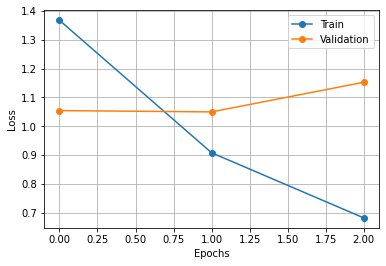

In [ ]:
plot_loss_vs_epochs(train_losses, validation_losses)

**Save the model**

After training, i save the model parameters in a file. I make the evaluations in different notebooks.

In [ ]:
torch.save(model.state_dict(), "model.pt")